In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat May  3 17:48:11 2025

@author: tunahan
"""
import torch
torch.cuda.empty_cache()
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision
from torchvision import transforms, datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Dataset sınıfı
class TransformData(Dataset):
    def __init__(self, subset, transform):
        self.transform = transform
        self.subset = subset
        
    def __getitem__(self, index):
        image, label = self.subset[index]
        image = self.transform(image)
        return image, label
    
    def __len__(self):
        return len(self.subset)

# Veri seti yükleme
dataset = torchvision.datasets.ImageFolder("/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer")

# Eğitim ve test veri setleri için transformlar
train_transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Boyutu küçültme
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),  # Daha az rotasyon
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Veri setinin bölünmesi
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_subset, test_subset = random_split(dataset, [train_size, test_size])

train_dataset = TransformData(train_subset, train_transform)
test_dataset = TransformData(test_subset, test_transform)

# DataLoader'lar
batch_size = 128  # Batch size'ı küçülttük
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=False)

# Model sınıfı
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # [B, 32, 256, 256]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # [B, 64, 128, 128]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # [B, 128, 64, 64]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # [B, 256, 32, 32]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # [B, 256, 16, 16]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),  # [B, 256, 8, 8]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 8 * 8, 1024), 
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 3)  # Çıkış katmanı
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Modeli GPU'ya gönderme
model = Cnn()
model = torch.nn.DataParallel(model)
model = model.to("cuda")

# Eğitim fonksiyonu
def train_model(model, dataloader, criterion, optimizer, scheduler):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(dataloader):
        images, labels = images.to("cuda"), labels.to("cuda")
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        total += images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (labels == preds).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Değerlendirme fonksiyonu
def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Optimizer ve kriterler
epochs = 25
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Eğitim ve değerlendirme döngüsü
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, scheduler)
    val_loss, val_acc = evaluate(model, test_loader, criterion)
    scheduler.step()
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
    print(f"  LR: {scheduler.get_last_lr()[0]:.6f}")
# Sınıf adlarını al (ImageFolder'dan)




100%|██████████| 10/10 [00:13<00:00,  1.35s/it]


Epoch 1/25
  Train Loss: 0.9659, Acc: 0.4858
  Val   Loss: 0.7261, Acc: 0.6865
  LR: 0.001000


100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


Epoch 2/25
  Train Loss: 0.6627, Acc: 0.7143
  Val   Loss: 0.6413, Acc: 0.7343
  LR: 0.001000


100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


Epoch 3/25
  Train Loss: 0.6026, Acc: 0.7469
  Val   Loss: 0.5901, Acc: 0.7673
  LR: 0.001000


100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


Epoch 4/25
  Train Loss: 0.5380, Acc: 0.7841
  Val   Loss: 0.5358, Acc: 0.7863
  LR: 0.001000


100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


Epoch 5/25
  Train Loss: 0.5341, Acc: 0.7824
  Val   Loss: 0.5040, Acc: 0.8152
  LR: 0.001000


100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


Epoch 6/25
  Train Loss: 0.4629, Acc: 0.8190
  Val   Loss: 0.4836, Acc: 0.8152
  LR: 0.001000


100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


Epoch 7/25
  Train Loss: 0.4293, Acc: 0.8322
  Val   Loss: 0.4641, Acc: 0.8251
  LR: 0.001000


100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


Epoch 8/25
  Train Loss: 0.3742, Acc: 0.8567
  Val   Loss: 0.3793, Acc: 0.8564
  LR: 0.001000


100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


Epoch 9/25
  Train Loss: 0.3343, Acc: 0.8747
  Val   Loss: 0.3531, Acc: 0.8729
  LR: 0.001000


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


Epoch 10/25
  Train Loss: 0.3158, Acc: 0.8768
  Val   Loss: 0.3180, Acc: 0.8886
  LR: 0.000100


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


Epoch 11/25
  Train Loss: 0.2256, Acc: 0.9176
  Val   Loss: 0.2975, Acc: 0.8944
  LR: 0.000100


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


Epoch 12/25
  Train Loss: 0.2083, Acc: 0.9226
  Val   Loss: 0.2778, Acc: 0.9068
  LR: 0.000100


100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


Epoch 13/25
  Train Loss: 0.1943, Acc: 0.9284
  Val   Loss: 0.2777, Acc: 0.9084
  LR: 0.000100


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


Epoch 14/25
  Train Loss: 0.1838, Acc: 0.9344
  Val   Loss: 0.2617, Acc: 0.9076
  LR: 0.000100


 47%|████▋     | 18/38 [00:25<00:28,  1.40s/it]


KeyboardInterrupt: 

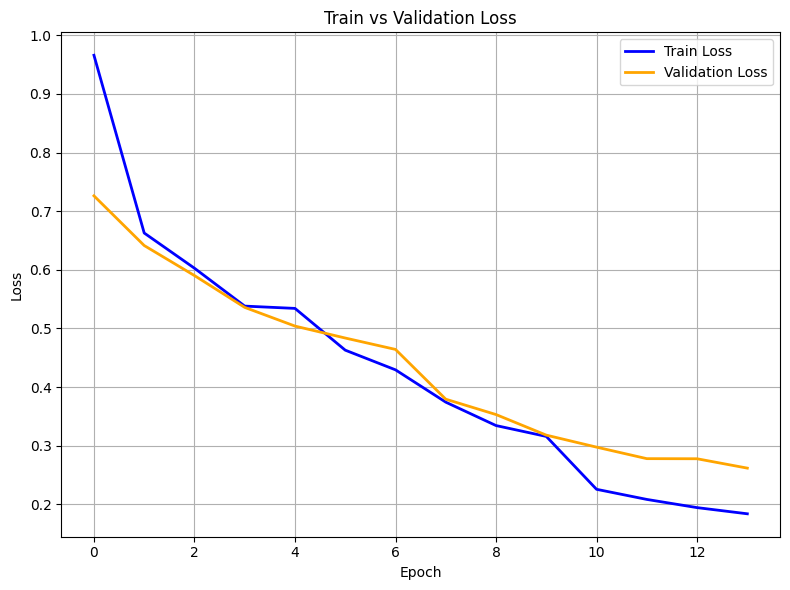

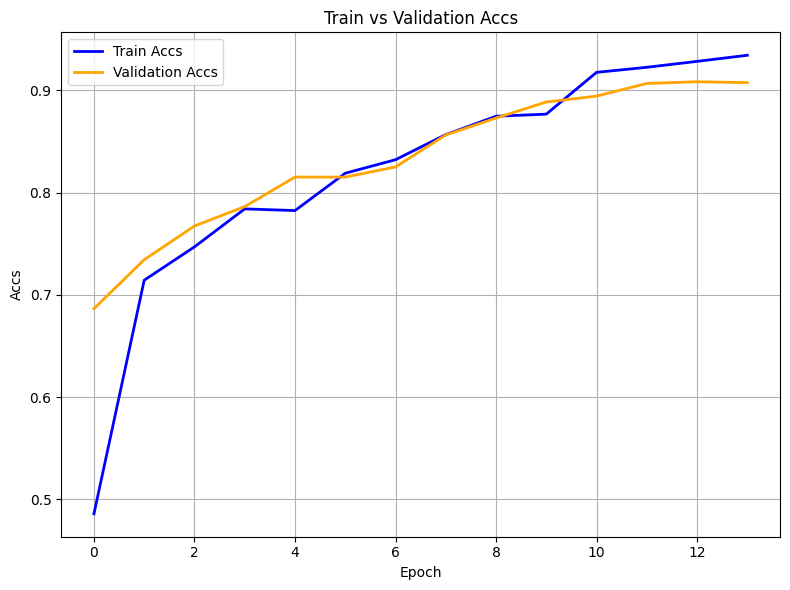

Macro ROC AUC: 0.9803
Micro ROC AUC: 0.9806


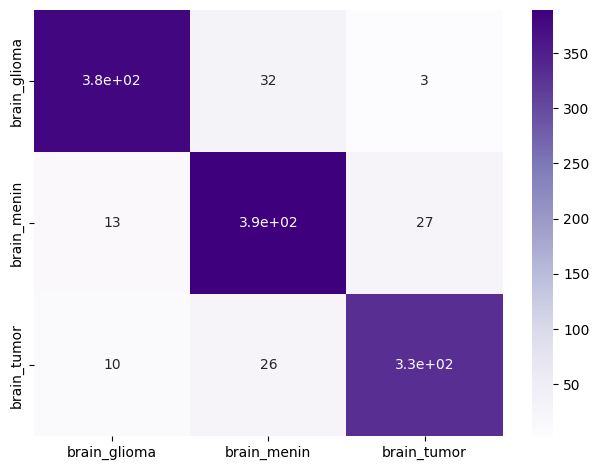

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       415
           1       0.87      0.91      0.89       429
           2       0.92      0.90      0.91       368

    accuracy                           0.91      1212
   macro avg       0.91      0.91      0.91      1212
weighted avg       0.91      0.91      0.91      1212



In [2]:
# Eğitim sürecini görselleştirme
plt.figure(figsize=(8,6))
plt.plot(train_losses, label="Train Loss", color='blue', linewidth=2)
plt.plot(val_losses, label="Validation Loss", color='orange', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(train_accs, label="Train Accs", color='blue', linewidth=2)
plt.plot(val_accs, label="Validation Accs", color='orange', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Accs")
plt.title("Train vs Validation Accs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

class_names = dataset.classes

# Test model (argmax prediction)
def test_model(model, dataloader, dtype="test"):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

# Softmax ile olasılık çıktısı alınan test
def test_model_softmax(model, dataloader):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = model(images)
            probs = nn.functional.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_probs, all_labels

# ROC ve confusion matrix hesaplama
train_preds, train_labels = test_model(model, train_loader, dtype="train")
test_preds, test_labels = test_model(model, test_loader, dtype="test")
test_probs, test_labels = test_model_softmax(model, test_loader)

roc_auc_macro = roc_auc_score(test_labels, test_probs, average="macro", multi_class="ovr")
roc_auc_micro = roc_auc_score(test_labels, test_probs, average="micro", multi_class="ovr")

cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, cmap="Purples", xticklabels=class_names, yticklabels=class_names, annot=True)
plt.tight_layout()
plt.show()
print(f"Macro ROC AUC: {roc_auc_macro:.4f}")
print(f"Micro ROC AUC: {roc_auc_micro:.4f}")
print(classification_report(test_labels, test_preds))

In [23]:
# YERİNE BUNU KULLAN
model = Cnn().to("cuda")  # DataParallel kullanma
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)  # Burada sadece backward_hook'u kullanıyoruz

    def generate(self, input_tensor, class_idx=None):
        input_tensor.requires_grad_()  # Gradients hesaplanabilmesi için
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        loss = output[0, class_idx]
        self.model.zero_grad()
        loss.backward()

        # Global Average Pooling
        weights = self.gradients.mean(dim=[2, 3], keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = torch.nn.functional.relu(cam)

        # Normalize to [0,1]
        cam = cam.squeeze().cpu().numpy()
        cam = cv2.resize(cam, (input_tensor.size(3), input_tensor.size(2)))
        cam = (cam - cam.min()) / (cam.max() - cam.min())

        return cam


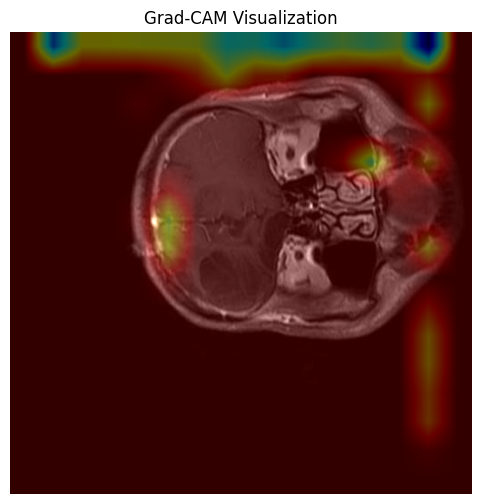

In [30]:
# Görüntü yükle ve hazırla
img_path = "/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer/brain_glioma/brain_glioma_0001.jpg"
img = Image.open(img_path).convert("L")
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
input_tensor = transform(img).unsqueeze(0).to("cuda")

# Grad-CAM üret
target_layer = model.features[-3]  
cam_generator = GradCAM(model, target_layer)
cam = cam_generator.generate(input_tensor)

# Görselleştir
img_np = np.array(img.resize((512, 512)))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
img_gray3 = np.stack([img_np / 255] * 3, axis=2)
overlay = heatmap * 0.4 + img_gray3

# Göster
plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.axis("off")
plt.title("Grad-CAM Visualization")
plt.show()
